# Analisis of business health

On this analisis I have defined the following KPIs:

- Number of sessions per month and company type
- Number of clients lost per month and company type
- Total and percentage profit per month and company type

This KPIs are based on the database that has been created on the Docker container __app__ that has the scrip __app.py__ in where the tables are created and populated with fake data.

![alt text](img/db_image.png "Database")

The database has 3 tables:

- sessions
- companies
- subscriptions

For the calculation of all the KPIs I only used SQL for handling all the data aggregations and transformations.

In [52]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# Database params
POSTGRES_HOST='localhost'
POSTGRES_PASSWORD='password'
POSTGRES_USER='user'
POSTGRES_DB='db'

# Get the connection to the database
def get_db_conn():
    conn = psycopg2.connect(f"dbname='{POSTGRES_DB}' user='{POSTGRES_USER}' host='{POSTGRES_HOST}' password='{POSTGRES_PASSWORD}'")
    conn.autocommit = True
    return(conn)

# Create a bar plot
def bar_plot(date,col1,label1,col2,label2,title,ylable,type="default"):
    width = 0.35
    x = np.arange(len(date))
    fig, ax = plt.subplots(figsize=(14,5))

    if(type == "stacked"):
        rects1 = ax.bar(date, col1, 0.35, label=label1)
        rects2 = ax.bar(date, col2, 0.35, bottom=col1, label=label2)
        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
    else:
        rects1 = ax.bar(x - width/2, col1, 0.35, label=label1)
        rects2 = ax.bar(x + width/2, col2, 0.35, label=label2)
        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)

    ax.set_ylabel(ylable)
    ax.set_title(title)
    ax.legend()

    ax.set_xticks(x, date)
    fig.tight_layout()

    plt.show()

## Number of sessions per month and company type <a name="1"></a>

In [53]:
# Connect to the database
conn = get_db_conn()
cur = conn.cursor()

cur.execute("""
            SELECT year || '-' || month AS date,
                   COUNT(*) AS number_companies,
                   SUM(CASE WHEN company_size = 'large' THEN 1 ELSE 0 END) AS number_companies_large,
                   SUM(CASE WHEN company_size = 'small' THEN 1 ELSE 0 END) AS number_companies_small,
                   SUM(number_sessions) AS total_sessions,
                   SUM(CASE WHEN company_size = 'large' THEN number_sessions ELSE 0 END) AS total_sessions_large,
                   SUM(CASE WHEN company_size = 'small' THEN number_sessions ELSE 0 END) AS total_sessions_small
            FROM (
                SELECT session_company_id AS company_id, 
                       EXTRACT(YEAR FROM session_created_at) AS year, 
                       EXTRACT(MONTH FROM session_created_at) AS month,
                       COUNT(*) AS number_sessions
                FROM sessions
                GROUP BY session_company_id, year, month
            ) AS t0
            INNER JOIN companies AS t1 ON t0.company_id = t1.company_id
            GROUP BY year, month
            ORDER BY year, month;
            """)
 
sessions = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])

cur.close()
sessions.head(100)

,date,number_companies,number_companies_large,number_companies_small,total_sessions,total_sessions_large,total_sessions_small
0,2021-1,478,174,304,3386,1734,1652
1,2021-2,452,169,283,3494,1907,1587
2,2021-3,423,160,263,3013,1699,1314
3,2021-4,390,152,238,3000,1641,1359
4,2021-5,366,147,219,2881,1616,1265
5,2021-6,335,137,198,2472,1476,996
6,2021-7,314,132,182,2290,1350,940
7,2021-8,297,130,167,2302,1408,894
8,2021-9,282,126,156,2269,1480,789
9,2021-10,257,125,132,2129,1409,720


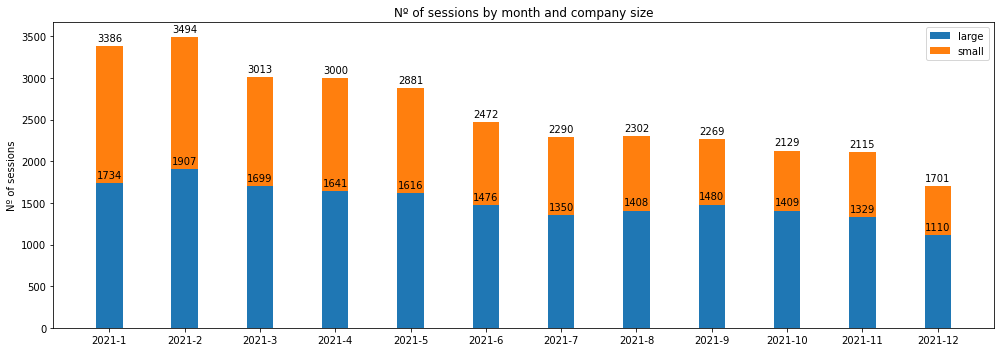

In [54]:
# Nº of sessions by month and company size
bar_plot(sessions.date, sessions.total_sessions_large, 'large', sessions.total_sessions_small, 'small', 'Nº of sessions by month and company size', 'Nº of sessions','stacked')

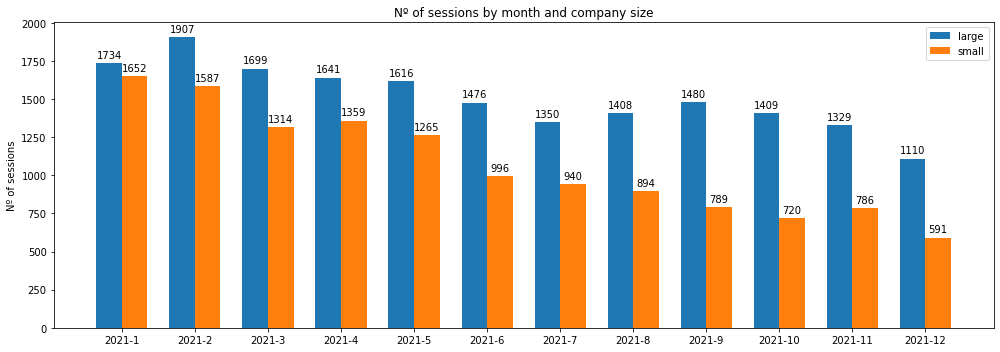

In [55]:
# Nº of sessions by month and company size
bar_plot(sessions.date, sessions.total_sessions_large, 'large', sessions.total_sessions_small, 'small', 'Nº of sessions by month and company size', 'Nº of sessions')

## Total and percentage profit per month and company type

In [59]:
# Connect to the database
conn = get_db_conn()
cur = conn.cursor()

cur.execute("""
            SELECT date,
                   number_large_clients,
                   number_small_clients,
                   profit_large_clients,
                   profit_small_clients,
                   ROUND(profit_large_clients::numeric*100/total_profit_clients::numeric,2) AS percentage_profit_large_clients,
                   ROUND(profit_small_clients::numeric*100/total_profit_clients::numeric,2) AS percentage_profit_small_clients
            FROM (
                SELECT year || '-' || month AS date,
                    SUM(CASE WHEN company_size = 'large' THEN 1 ELSE 0 END) AS number_large_clients,
                    SUM(CASE WHEN company_size = 'small' THEN 1 ELSE 0 END) AS number_small_clients,
                    SUM(CASE WHEN company_size = 'large' THEN sub_price ELSE 0 END) AS profit_large_clients,
                    SUM(CASE WHEN company_size = 'small' THEN sub_price ELSE 0 END) AS profit_small_clients,
                    SUM(sub_price) AS total_profit_clients
                FROM ( 
                    SELECT session_company_id AS company_id, 
                        EXTRACT(YEAR FROM session_created_at) AS year, 
                        EXTRACT(MONTH FROM session_created_at) AS month 
                    FROM sessions
                    GROUP BY session_company_id, year, month
                ) AS t0 
                INNER JOIN companies AS t1 ON t0.company_id = t1.company_id
                INNER JOIN subscriptions AS t2 ON t1.company_size = t2.sub_id
                GROUP BY year, month
                ORDER BY year, month
            ) AS final;
            """)

profit = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])
cur.close()
profit.head(100)

,date,number_large_clients,number_small_clients,profit_large_clients,profit_small_clients,percentage_profit_large_clients,percentage_profit_small_clients
0,2021-1,174,304,17226,5776,74.89,25.11
1,2021-2,169,283,16731,5377,75.68,24.32
2,2021-3,160,263,15840,4997,76.02,23.98
3,2021-4,152,238,15048,4522,76.89,23.11
4,2021-5,147,219,14553,4161,77.77,22.23
5,2021-6,137,198,13563,3762,78.29,21.71
6,2021-7,132,182,13068,3458,79.08,20.92
7,2021-8,130,167,12870,3173,80.22,19.78
8,2021-9,126,156,12474,2964,80.80,19.20
9,2021-10,125,132,12375,2508,83.15,16.85


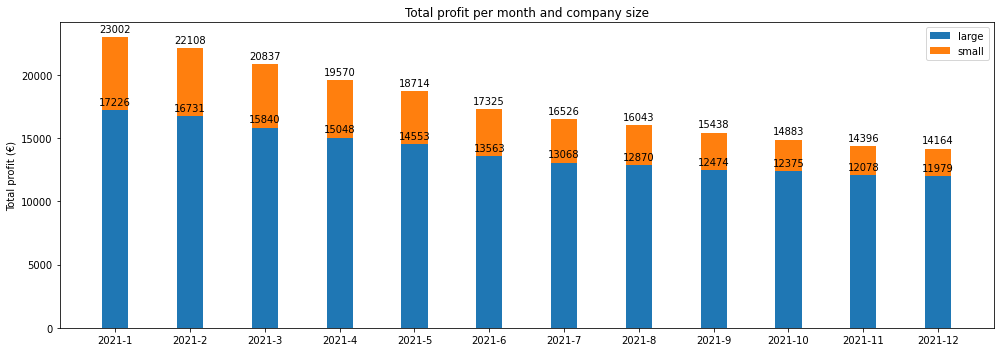

In [60]:
# Total profit per month and company size
bar_plot(profit.date, profit.profit_large_clients, 'large', profit.profit_small_clients, 'small', 'Total profit per month and company size', 'Total profit (€)','stacked')

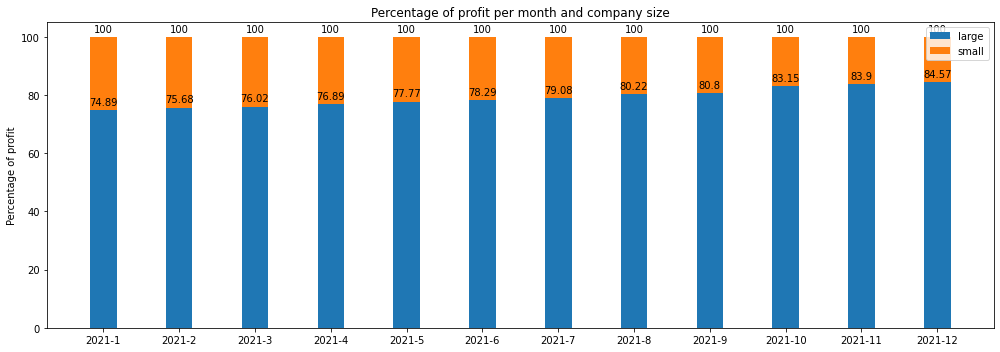

In [61]:
# Percentage of profit per month and company size
bar_plot(profit.date, profit.percentage_profit_large_clients, 'large', profit.percentage_profit_small_clients, 'small', 'Percentage of profit per month and company size', 'Percentage of profit','stacked')

## Number of clients lost per month and company type

In [56]:
# Connect to the database
conn = get_db_conn()
cur = conn.cursor()

cur.execute("""
            WITH number_companies AS (
              SELECT ROW_NUMBER() OVER (ORDER BY (SELECT 1)) AS number,
                     date,
                     number_companies,
                     number_companies_large,
                     number_companies_small
              FROM (
                     SELECT year || '-' || month AS date,
                            COUNT(*) AS number_companies,
                            SUM(CASE WHEN company_size = 'large' THEN 1 ELSE 0 END) AS number_companies_large,
                            SUM(CASE WHEN company_size = 'small' THEN 1 ELSE 0 END) AS number_companies_small
                     FROM (
                            SELECT session_company_id AS company_id, 
                                   EXTRACT(YEAR FROM session_created_at) AS year, 
                                   EXTRACT(MONTH FROM session_created_at) AS month
                            FROM sessions
                            GROUP BY session_company_id, year, month
                     ) AS t0
                     INNER JOIN companies AS t1 ON t0.company_id = t1.company_id
                     GROUP BY year, month
                     ORDER BY year, month
              ) AS t1
            )
            SELECT date,
                   lost_clients,
                   SUM(lost_clients) OVER (ORDER BY number ASC) AS total_lost_clients,
                   lost_clients_large,
                   SUM(lost_clients_large) OVER (ORDER BY number ASC) AS total_lost_clients_large,
                   lost_clients_small,
                   SUM(lost_clients_small) OVER (ORDER BY number ASC) AS total_lost_clients_small
            FROM (
              SELECT current_month.date AS date,
                     current_month.number AS number,
                     CASE WHEN old_month.number_companies IS NULL THEN 0 ELSE old_month.number_companies - current_month.number_companies END AS lost_clients,
                     CASE WHEN old_month.number_companies_large IS NULL THEN 0 ELSE old_month.number_companies_large - current_month.number_companies_large END AS lost_clients_large,
                     CASE WHEN old_month.number_companies_small IS NULL THEN 0 ELSE old_month.number_companies_small - current_month.number_companies_small END AS lost_clients_small
              FROM number_companies AS current_month
              LEFT JOIN number_companies AS old_month ON current_month.number = old_month.number+1
            ) AS final;
            """)

lost_clients = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])
cur.close()
lost_clients.head(100)

,date,lost_clients,total_lost_clients,lost_clients_large,total_lost_clients_large,lost_clients_small,total_lost_clients_small
0,2021-1,0,0,0,0,0,0
1,2021-2,26,26,5,5,21,21
2,2021-3,29,55,9,14,20,41
3,2021-4,33,88,8,22,25,66
4,2021-5,24,112,5,27,19,85
5,2021-6,31,143,10,37,21,106
6,2021-7,21,164,5,42,16,122
7,2021-8,17,181,2,44,15,137
8,2021-9,15,196,4,48,11,148
9,2021-10,25,221,1,49,24,172


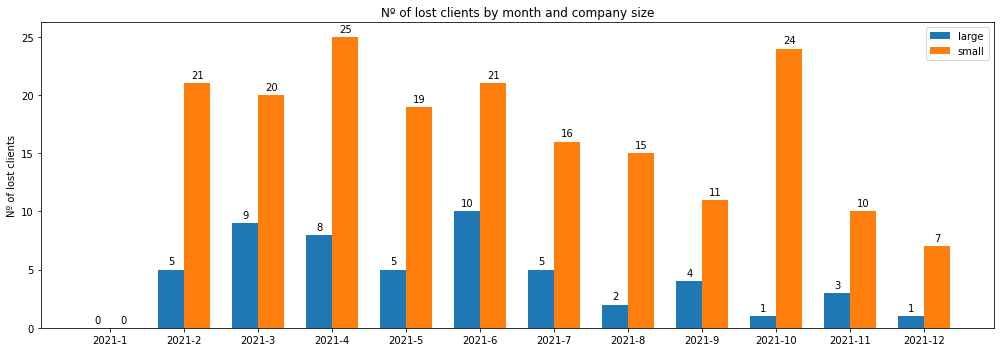

In [63]:
# Nº of lost clients by month and company size
bar_plot(lost_clients.date, lost_clients.lost_clients_large, 'large', lost_clients.lost_clients_small, 'small', 'Nº of lost clients by month and company size', 'Nº of lost clients')

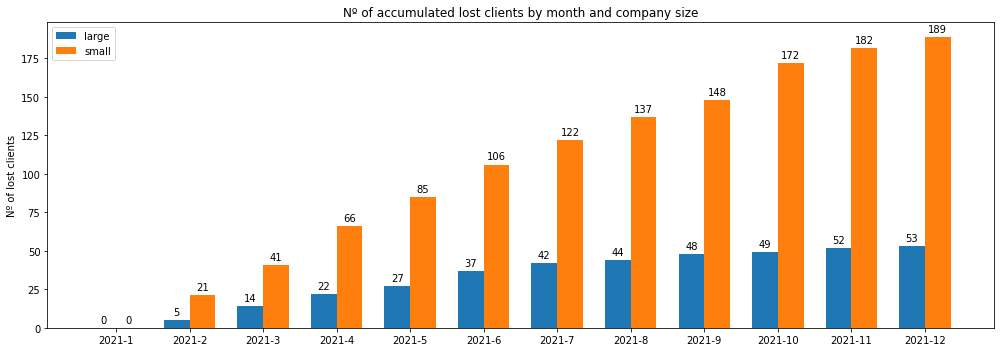

In [64]:
# Nº of accumulated lost clients by month and company size
bar_plot(lost_clients.date, lost_clients.total_lost_clients_large, 'large', lost_clients.total_lost_clients_small, 'small', 'Nº of accumulated lost clients by month and company size', 'Nº of lost clients')